# Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_and_preprocess(rides_file_path, stations_file_path):
    '''
    This function is used to read a rides file and all other necessary files and do the preprocessing.
    
    :param str rides_file_path: path to the rides file
    :param str stations_file_path: path to the stations file
    :return pd.DataFrame: dataframe ready to be used in the modelling process
    '''
    
    rides_df = pd.read_csv(rides_file_path, parse_dates=[0, 2])
    stations_df = pd.read_csv(stations_file_path)
    
    # turn all column names to lower case
    rides_df.columns = rides_df.columns.str.lower()
    stations_df.columns = stations_df.columns.str.lower()
    
    # this happens in file of August 2019, because of invalid station codes
    if rides_df['start_station_code'].dtype != 'int':
        
        # add column for integer values, insert None when a value can not be converted
        def to_int_or_none(val):
            try:
                return(int(val))
            except ValueError:
                return None

        rides_df['start_station_code_int'] = rides_df['start_station_code'].apply(to_int_or_none)
        rides_df['end_station_code_int'] = rides_df['end_station_code'].apply(to_int_or_none)

        # drop every row where station codes could not be converted to integer
        rides_df = rides_df.dropna()
        rides_df['start_station_code'] = rides_df['start_station_code_int'].astype('int')
        rides_df['end_station_code'] = rides_df['end_station_code_int'].astype('int')
        rides_df = rides_df.drop(columns=['start_station_code_int', 'end_station_code_int'])
    
    # aggregate rides: sum up rides between 0:00 to 12:00 and 12:00 to 0:00
    ride_counts_df = rides_df.groupby([pd.Grouper(key='start_date', freq='12h'), 'start_station_code'])['end_date'].count()
    ride_counts_df = ride_counts_df.to_frame()
    ride_counts_df = ride_counts_df.rename(columns={'end_date': 'count'})
    ride_counts_df = ride_counts_df.reset_index()
    
    # add am/pm flags (am = 0, pm = 1)
    ride_counts_df['pm'] = ride_counts_df['start_date'].dt.hour.map({0: 0, 12: 1})
    
    # join coordinates of stations
    ride_counts_df = ride_counts_df.merge(
        stations_df[['code', 'latitude', 'longitude']],
        left_on='start_station_code',
        right_on='code',
        # inner join removes any station not specified in the stations dataset
        how='inner'
    )
    
    # add month and weekday
    ride_counts_df['month'] = ride_counts_df['start_date'].dt.month
    ride_counts_df['weekday'] = ride_counts_df['start_date'].dt.weekday
    
    # add holy day flag
    # ...
    
    # add weather data
    # ...
    
    # add distance to city center
    # ...
    
    # only keep these columns
    ride_counts_df = ride_counts_df[['latitude', 'longitude', 'month', 'weekday', 'pm', 'count']] # ...
    
    return ride_counts_df
    

In [3]:
ride_counts_df = pd.DataFrame()

for year in range(2017, 2020):
    stations_file_path = f'data/{year}/Stations_{year}.csv'
    for month in range(4, 10):
        rides_file_path = f'data/{year}/OD_{year}-{month:02d}.csv'
        # run preprocessing function and append df
        month_df = read_and_preprocess(rides_file_path, stations_file_path)
        ride_counts_df = pd.concat([ride_counts_df, month_df]).reset_index(drop=True)
        
print(ride_counts_df.info())
ride_counts_df.head()

/tmp/ipykernel_5517/410470113.py:10: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  rides_df = pd.read_csv(rides_file_path, parse_dates=[0, 2])
/tmp/ipykernel_5517/410470113.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_df['start_station_code'] = rides_df['start_station_code_int'].astype('int')
/tmp/ipykernel_5517/410470113.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_df['end_station_code'] = rides_df['end_station_code_int']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553635 entries, 0 to 553634
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   553635 non-null  float64
 1   longitude  553635 non-null  float64
 2   month      553635 non-null  int64  
 3   weekday    553635 non-null  int64  
 4   pm         553635 non-null  int64  
 5   count      553635 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 25.3 MB
None


,latitude,longitude,month,weekday,pm,count
0,45.533703,-73.515283,4,5,0,1
1,45.533703,-73.515283,4,0,1,1
2,45.533703,-73.515283,4,2,0,1
3,45.533703,-73.515283,4,3,1,1
4,45.533703,-73.515283,4,4,0,1


In [4]:
ride_counts_df['count'].describe()

count    553635.000000
mean         24.626890
std          27.418968
min           1.000000
25%           8.000000
50%          16.000000
75%          31.000000
max         582.000000
Name: count, dtype: float64

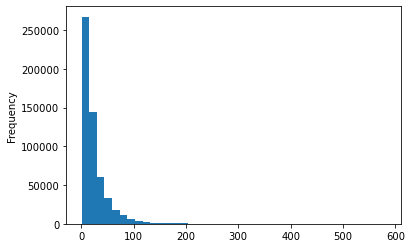

In [5]:
ride_counts_df['count'].plot(kind='hist', bins=40)

plt.show()